## Multidimensional Scaling

I decided to try and implement a MDS model without really knowing anything about MDS.

I know that, generally, it takes pairwise distances between points and infers the most likley configuration of points in an N-dimensional space to produce those distances.

The formulation I have here gets much worse results than I'm sure are possible, but it's pretty cool that it kind of finds the clusters.

Something I'm doing is pushing the points onto a straight line, which gets worse the larger sigma is on my gaussian distance precision prior.

In [1]:
import pyjags
import os

# this import assumes pjbcmassistant.py is ONE folder
# above this notebook. You may need to redirect it if
# you get a ModuleNotFoundError.
nb_path = os.getcwd()
parent_path = os.path.split(nb_path)[0]
os.chdir(parent_path)
from pjbcmassistant import ModelHandler, SampleHandler
os.chdir(nb_path)

### Building the source data

This generates a collection of points that have ground-truth coordinates.
Then, builds a matrix of pairwise distances for the model to use to infer their coordinates.

In [2]:
import random
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

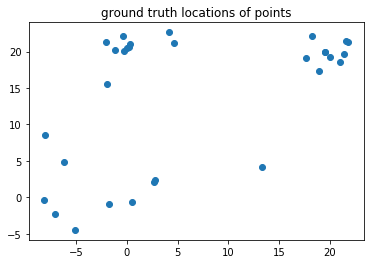

In [4]:
class Point:
    def __init__(self, maxdist, centerx, centery):
        angle = 2*np.pi*np.random.sample(1)
        distance = maxdist*np.random.sample(1)
        self.x = distance*np.cos(angle) + centerx
        self.y = distance*np.sin(angle) + centery
        
        
    def getdist(self, right):
        return np.sqrt((self.x-right.x)**2+(self.y-right.y)**2)

    def setcoords(self, x, y):
        self.x = x
        self.y = y
        
    def getcoords(self):
        return np.array((self.x, self.y)).squeeze(1)
    
    def getx(self):
        return self.x
    
    def gety(self):
        return self.y
    
    def __str__(self):
        return f'{self.x},{self.y}'
        
def genclouds(paramlist,pointspercloud):
    pointlist = []
    for params in paramlist:
        pointlist.extend([Point(*params) for i in range(pointspercloud)])
        
    
    
    coordarray = np.array([point.getcoords() for point in pointlist])

    x = coordarray[:,0]
    y = coordarray[:,1]
    
    return x, y, pointlist
    


datax, datay, pointlist = genclouds([(15, 0, 0),(3,20,20),(5, 0, 20)],10)

plt.title('ground truth locations of points')
plt.scatter(datax,datay);

distmatrix = pd.DataFrame(columns=range(len(pointlist)),index=range(len(pointlist)))

for i1, p1 in enumerate(pointlist):
    for i2, p2 in enumerate(pointlist):
        distmatrix.iat[i1,i2] = np.asscalar(p1.getdist(p2))

distmatrix.head()

distance_vals = distmatrix.values

In [5]:
spec_string = """
model:
isaiahmds.txt

settings:
chains = 3
samples = 1000
thinning = 0
burnin = 1000

data:
#calculated below with setdata method.

sample:
x
y

"""

model_spec = ModelHandler(spec_string)

model_spec.set_data('distance', distance_vals)
model_spec.set_data('npoints', len(distance_vals))

pyjags_model = pyjags.Model(**model_spec.get_model_args())
sample_data = pyjags_model.sample(**model_spec.get_sample_args())

sample_handler = SampleHandler(sample_data)

adapting: iterations 3000 of 3000, elapsed 0:00:03, remaining 0:00:00
sampling: iterations 3000 of 3000, elapsed 0:00:03, remaining 0:00:00


In [6]:
import numpy


data_dict = model_spec.data


masked_data = np.ma.masked_invalid(data_dict['distance'][0].astype('float'))
# masked_data = {data_var:np.ma.masked_invalid(data_dict[data_var]) for data_var in data_dict}

In [7]:
data_dict['distance'][-1].astype('float')

array([22.60428369, 20.97034791, 21.19192801, 17.02130526, 18.36523146,
       14.60343224, 21.56886371, 23.93451857, 25.582071  , 18.56930781,
       19.86689278, 18.11007353, 20.89094895, 21.62542184, 21.15861452,
       18.97985125, 19.27034333, 17.53771334, 19.28845965, 21.39637065,
        1.43992953,  0.43399172,  4.46296802,  5.53308028,  2.35767538,
        4.4785786 ,  0.72379905,  1.72201608,  0.22175419,  0.        ])

In [8]:
print(model_spec.model)

#In which Isaiah attempts a multidimensional scaling model
model{
  for (i in 1:npoints){
      x[i] ~ dunif(-30,30) #x value
      y[i] ~ dunif(-30,30) #y value
    for (j in (i):npoints){
      calculateddistance[i,j] <- sqrt(pow((x[i]-x[j]),2)+pow((y[i]-y[j]),2))  
      distance[i,j] ~ dnorm(calculateddistance[i,j], lambda)
    }
  }
  sigma <- .02 #~ dunif(0,1) #supposing we don't think our distance measure is that great
  lambda <- 1/pow(sigma,2)  
}



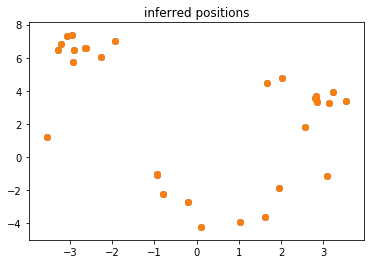

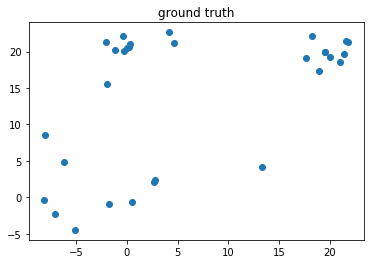

In [9]:
sample_handler.summarize(suppress=True)

xvals = [sample_handler.get_statistic('x_'+str(i),'mean') for i in range(30)]
yvals = [sample_handler.get_statistic('y_'+str(i),'mean') for i in range(30)]

# plt.xlim(-30,30)
# plt.ylim(-30,30)
plt.title('inferred positions')
plt.scatter(xvals,yvals);

plt.title('inferred positions')
plt.scatter(xvals,yvals);
plt.show();

plt.title('ground truth')
plt.scatter(datax,datay);